<i>Copyright (c) Microsoft Corporation. All rights reserved.</i>

<i>Licensed under the MIT License.</i>

# Multi-label Classification

In this notebook, we will look at the best practices for doing multilabel classification. 

In the previous notebook, we performed multi-class/single-label classification, where each image is assigned to only one label. For single-label classification, a picture of a single animal can be either a dog or a cat but not both at the same time. For multi-label classification, each image can contain or represent multiple different labels: a landscape can be labeled both gloomy (weather) and of a beach (subject).

In this notebook, we'll train a multi-label classifier. We will also examine how best to structure data for multi-label classification problems, and learn about new ways to evaluate our results. 

In [1]:
# Ensure edits to libraries are loaded and plotting is shown in the notebook.
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Import all the functions we need.

In [2]:
import sys
sys.path.append("../../")

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from pathlib import Path
import scrapbook as sb

# fastai
import fastai
from fastai.vision import (
    models, ImageList, imagenet_stats, cnn_learner, partial
)

# local modules
from utils_cv.classification.model import (
    TrainMetricsRecorder, hamming_accuracy, zero_one_accuracy, get_optimal_threshold,
)
from utils_cv.classification.plot import plot_thresholds
from utils_cv.classification.data import Urls
from utils_cv.common.data import unzip_url
from utils_cv.common.gpu import db_num_workers, which_processor

print(f"Fast.ai version = {fastai.__version__}")
which_processor()

Fast.ai version = 1.0.48
Fast.ai (Torch) is using GPU: Tesla V100-PCIE-16GB


Like before, we set some parameters. This time, we can use one of the multi-label datasets that come with this repo.

In [3]:
DATA_PATH     = unzip_url(Urls.multilabel_fridge_objects_path, exist_ok=True)
EPOCHS        = 10
LEARNING_RATE = 1e-4
IM_SIZE       = 300
BATCH_SIZE    = 16
ARCHITECTURE  = models.resnet18

---

## 1. Prepare Image Data for Multi-label Classification

In this notebook, we'll look at different kinds of beverages. In the repo, under `data`, we've downloaded a directory titled: __multilabelFridgeObjects__.

Lets set that directory to our `path` variable, which we'll use throughout the notebook. We'll also inspect what's inside to get an understanding of how to structure images for multi-label classification.

In [4]:
path = Path(DATA_PATH)
path.ls()

[PosixPath('/data/home/pabuehle/Desktop/ComputerVision/data/multilabelFridgeObjects/images'),
 PosixPath('/data/home/pabuehle/Desktop/ComputerVision/data/multilabelFridgeObjects/models'),
 PosixPath('/data/home/pabuehle/Desktop/ComputerVision/data/multilabelFridgeObjects/labels.csv')]

Lets inspect the `/images` folder:

In [5]:
(path/'images').ls()[:5]

[PosixPath('/data/home/pabuehle/Desktop/ComputerVision/data/multilabelFridgeObjects/images/41.jpg'),
 PosixPath('/data/home/pabuehle/Desktop/ComputerVision/data/multilabelFridgeObjects/images/53.jpg'),
 PosixPath('/data/home/pabuehle/Desktop/ComputerVision/data/multilabelFridgeObjects/images/51.jpg'),
 PosixPath('/data/home/pabuehle/Desktop/ComputerVision/data/multilabelFridgeObjects/images/50.jpg'),
 PosixPath('/data/home/pabuehle/Desktop/ComputerVision/data/multilabelFridgeObjects/images/6.jpg')]

Lets also take a look at the `labels.csv` file using pandas. 

In [6]:
df = pd.read_csv(path/'labels.csv'); df.sample(5)

,filename,labels
12,13.jpg,carton can
86,87.jpg,carton can milk_bottle water_bottle
110,111.jpg,water_bottle carton
3,4.jpg,water_bottle
2,3.jpg,can


As shown above, the contents of the csv file is a mapping of the filename to the labels. Since this is a multi-label classification problem, each image can be associated to multiple labels.

This is one of the most common data formats for multi-label image classification; one csv file that contains the mapping of labels to a folder of images:

```
/images
+-- labels.csv
+-- images
|   +-- image1.jpg
|   +-- image2.jpg
|   +-- ...
|   +-- image131.jpg
|   +-- image132.jpg
```

## 2. Load labels and images

__Loading data__

Now that we know the structure of our data, lets use fast.ai's data block apis to create our databunches so that we can easily load mini-batches of data from our file system into our trainer.

In [7]:
np.random.seed(42)
data = (ImageList.from_csv(path, 'labels.csv', folder='images')
       .split_by_rand_pct(0.2, seed=10)
       .label_from_df(label_delim=' ')
       .transform(size=IM_SIZE)
       .databunch(bs=BATCH_SIZE, num_workers = db_num_workers())
       .normalize(imagenet_stats))

Lets break down the code:

The first thing we need to do is to create an `ImageList`, and we'll do so by creating it from a csv file (`from_csv`). Then we want to do a random split (`random_split_by_pct`) so that we have our validation set. For this method, we've also set a random seed (`np.random.seed(42)`) so that our validation set is consistent. Finally we want to get our labels from the dataframe df (`label_from_df`) that we built from the csv file. Since our labels are space-separated in the csv file, we want to specify that our labels will be delimited by a space (`label_delim=' '`). 

In the second part, we use the `ImageList` we created and apply a transformation on it (`transform`) so that all images are resized to 299X299. Then we turn it into a databunch, which is basically the kind of object fast.ai's trainer uses to load mini-batches of data. Finally, we'll normalize the databunch (`normalize(imagenet_states)`) to the ImageNet parameters.

__Inspect data__

To make sure our data is correctly loaded, let's print out the number of classes, and each of the class labels.

In [8]:
print(f'number of classes: {data.c}')
print(data.classes)

number of classes: 4
['can', 'carton', 'milk_bottle', 'water_bottle']


We can also call `batch_stats` on our databunch object to get a view of how the data is split between training and validation.

In [9]:
data.batch_stats

<bound method ImageDataBunch.batch_stats of ImageDataBunch;

Train: LabelList (103 items)
x: ImageList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: MultiCategoryList
carton,water_bottle,water_bottle,can,milk_bottle
Path: /data/home/pabuehle/Desktop/ComputerVision/data/multilabelFridgeObjects;

Valid: LabelList (25 items)
x: ImageList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: MultiCategoryList
milk_bottle,carton,water_bottle;carton;milk_bottle,carton;can,water_bottle;carton
Path: /data/home/pabuehle/Desktop/ComputerVision/data/multilabelFridgeObjects;

Test: None>

Let's get a sample of what the data looks like.

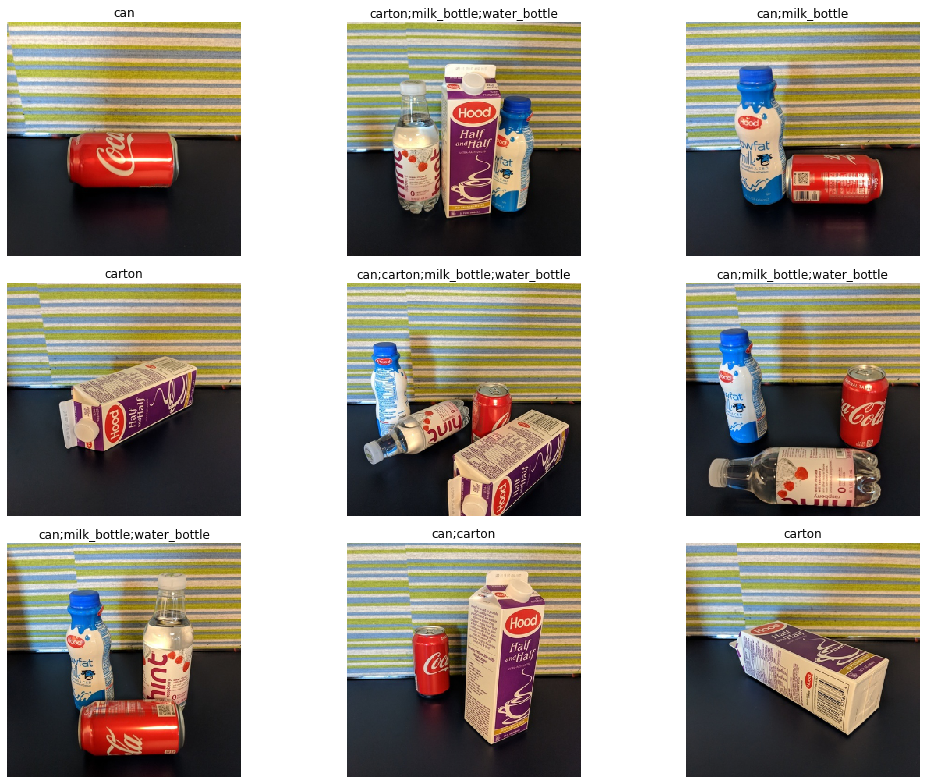

In [10]:
data.show_batch(rows=3, figsize=(15, 11))

# 3. Training our multi-label classifier

One of the main differences between training a multi-label classifier an a single-label classifier is the _evaluation metric(s)_ we use to evaluate our model.

__The Problem With Accuracy__

In traditional classification, accuracy is the most common evaluation criteria. But for multi-label classification problems, accuracy isn't as straight-forward of a concept. Do we care about label-level accuracy or do we care about image-level accuracy?

A prediction that contains a subset of the correct labels we're looking for can sometimes be better than one that contains none of them. For example, in an image that is labelled both 'rainy' and 'forest', it is usually better to predict one correct label than neither of the correct labels. However, sometimes we may still want to consider the prediction a misclassification unless _all_ the labels are correctly predicted. For multi-label classification, we'll use _hamming accuracy_ and _zero-one accuracy_ which we can respectively think of as label-level accuracy and image-level accuracy.

__Hamming Accuracy & Zero-one Accuracy__

One of the most common ways to evaluate a multi-label classification problem is by using the __hamming accuracy__, which we can think of as the fraction of wrong labels to the total number of labels. 

Zero-one accuracy is a much harsher evaluation metric than hamming accuracy. The __zero-one accuracy__ will classify an entire set of labels for a given sample incorrect if it does not entirely match the true set of labels. Hamming accuracy is more forgiving since it penalizes only the individual labels themselves.

Let's look at these two metrics with a concrete example. Let's say our validation set contains 5 images, each with 4 labels, and the results looks as such:
```
+-------+------------------+------------------+------------------+------------------+
| Image |  y_true:         |  y_pred:         |  hamming_acc:    |  zero_one_acc:   |
|-------+------------------+------------------+------------------+------------------+
| im_01 |  [[1, 0, 0, 1],  |  [[1, 0, 0, 0],  |  [[0, 0, 0, 1],  |  [[1],           |
| im_02 |   [1, 0, 1, 1],  |   [1, 1, 1, 1],  |   [0, 1, 0, 0],  |   [1],           |
| im_03 |   [0, 1, 0, 0],  |   [0, 1, 0, 0],  |   [0, 0, 0, 0],  |   [0],           |
| im_04 |   [0, 1, 1, 0],  |   [0, 1, 1, 0],  |   [0, 0, 0, 0],  |   [0],           |
| im_05 |   [1, 1, 0, 0]]  |   [1, 1, 1, 0]]  |   [0, 0, 1, 0]]  |   [1]]           |
+-------+------------------+------------------+------------------+------------------+
|                                             | = 3/20 incorrect | = 3/5 incorrect  |
+-------+------------------+------------------+------------------+------------------+
```
In this case, the predictions has 3 out of a total of 20 predictions that are not true, so the hamming accuracy is __0.85__. While there are only 3 misclassified labels, each of the misclassifications happen on a different image. So for calculating the zero-one accuracy, we end up with 3/5, or __0.4__. If we compare this to hamming accuracy, we can see that it is a much less forgiving metric.

While hamming and zero-one accuries are common evaluation metrics for multi-label classification, note that it may not be ideal for all multi-label classification problems. For each problem, you need to assess what you're evaluating your model against to see if it is a good fit. 

---

The following section covers training a model with fast.ai. It is very similar to the previous notebook, except for the evaluation metric that is used.

Since this is a multi-label classification problem, we'll want to use hamming and zero-one accuracy, as our evalution metric. Unlike traditional accuracy, fast.ai does not provide these metrics in their library, so we have to define them. To create our own metrics, we'll need to define a custom function that will take `y_pred` and `y_true`, and return a single metric. 

We've defined the hamming and zero-one accuracy functions in the `utils_cv.classification.models` module so we can use them directly when defining our `cnn_learner`. 

> To inspect the implementation of these functions, you can run:
> - `print(inspect.getsource(hamming_accuracy))`
> - `print(inpsect.getsource(zero_one_accuracy))`

In [11]:
learn = cnn_learner(
    data, 
    ARCHITECTURE, 
    metrics=[hamming_accuracy, zero_one_accuracy],
    callback_fns=[partial(TrainMetricsRecorder, show_graph=True)]
)

For multi-label classification, we need to use a different loss function, but you'll notice that we do not specify which to use. This is because fast.ai uses the passed-in databunch to detect that this is a multi-label classification problem (that each x maps to a y that has multiple labels) and automatically sets the appropriate loss function. In this case, we see that fast.ai has chosen to use Pytorch's [`BCEWithLogitsLoss`](https://pytorch.org/docs/0.3.0/nn.html#bcewithlogitsloss), which uses the sigmoid activation instead of a softmax.

For further details, we can inspect the loss function by calling `learn.loss_func??`. You can read more about how the [loss function differs in multi-label classification](#appendix-loss-function) in the appendix at the bottom of this notebook.

In [12]:
learn.loss_func

FlattenedLoss of BCEWithLogitsLoss()

We can not continue to train the model like we did in the previous notebook. We need to unfreeze our CNN, since we're training all the layers.

In [13]:
learn.unfreeze()

We can call the `fit` function to train the dnn.

epoch,train_loss,valid_loss,train_hamming_accuracy,valid_hamming_accuracy,train_zero_one_accuracy,valid_zero_one_accuracy,time
0,0.726955,0.644835,0.570312,0.510000,0.750000,0.080000,00:01
1,0.577762,0.542942,0.757812,0.730000,0.750000,0.200000,00:01
2,0.484807,0.459611,0.859375,0.790000,0.781250,0.320000,00:01
3,0.422524,0.399143,0.895833,0.820000,0.812500,0.320000,00:01
4,0.374879,0.356657,0.921875,0.850000,0.843750,0.400000,00:01
5,0.335726,0.323093,0.932292,0.890000,0.854167,0.560000,00:01
6,0.302154,0.309744,0.955729,0.890000,0.895833,0.600000,00:01
7,0.277748,0.292288,0.940104,0.900000,0.895833,0.640000,00:01
8,0.260287,0.276989,0.942708,0.900000,0.885417,0.640000,00:01
9,0.238428,0.267747,0.968750,0.920000,0.916667,0.720000,00:01


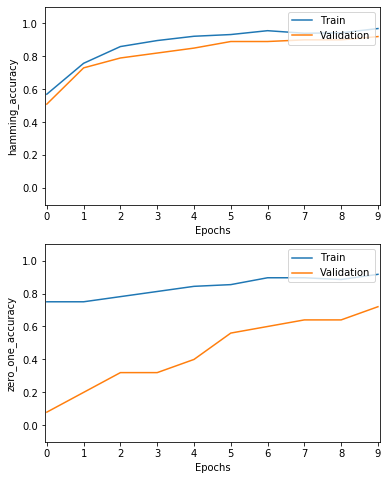

In [14]:
learn.fit(EPOCHS, LEARNING_RATE)

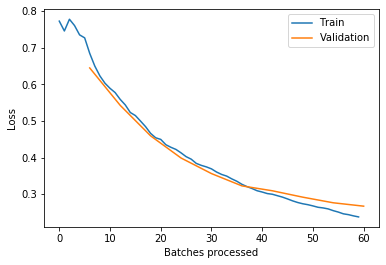

In [15]:
learn.recorder.plot_losses()

## 4. Evaluate the model

The learner comes with a handy function `show_results` that will show one mini-batch of the validation set. We can use that to get an intuitive sense of what is being predicted correctly and what is not.

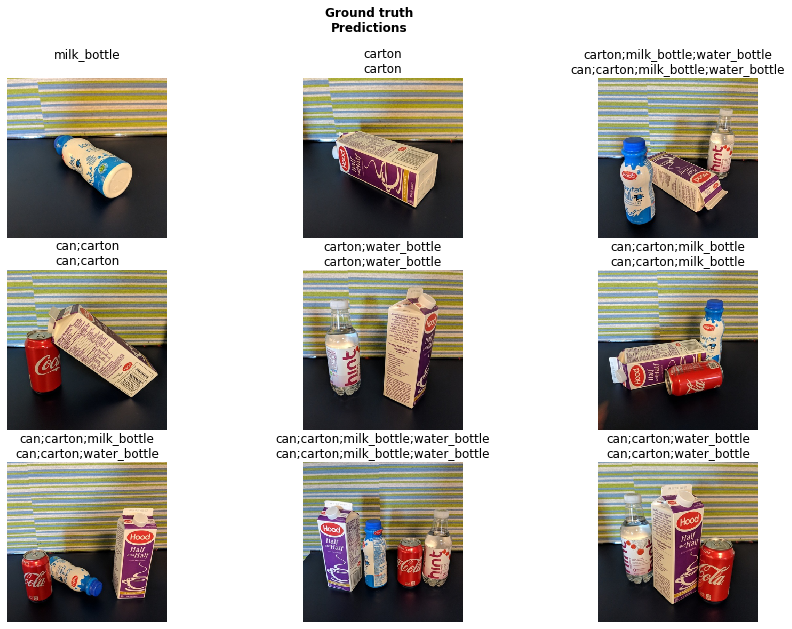

In [16]:
learn.show_results(rows=3, figsize=(15, 10))

To quantitatively evaluate our model, let's take a look at the hamming and zero-one accuracies on the validation set.

In [17]:
_, acc_hl, acc_zol = learn.validate(learn.data.valid_dl, metrics=[hamming_accuracy, zero_one_accuracy])
print(f'Hamming Accuracy on validation set: {float(acc_hl):3.2f}')
print(f'Zero-one Accuracy on validation set: {float(acc_zol):3.2f}')

Hamming Accuracy on validation set: 0.92
Zero-one Accuracy on validation set: 0.72


We've calculated the hamming and the zero-one accuracies on our validation set with the default probability threshold of 0.2. However, this default value may not be the most optimal value. We can use the `plot_thresholds` function to plot the evaluation metric at different levels of thresholds. If, for example, we were interested in the zero-one accuracy, but we noticed that the default threshold is far from the optimal point, we may consider using a different threshold when we perform inferencing. Let's plot the zero-one accuracy at various thresholds to what the most optimal threshold is.

Note that the threshold represents a trade-off between specificity and sensitivity. The higher the threshold, the higher the _specificity_. The lower the threshold, the higher the _sensivity_.

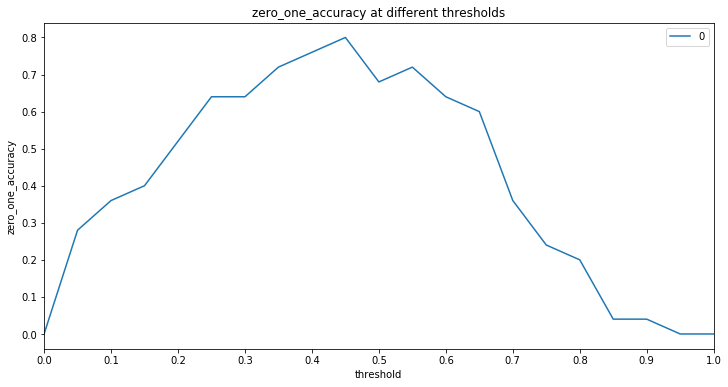

In [18]:
interp = learn.interpret()
plot_thresholds(zero_one_accuracy, interp.preds, interp.y_true)

To get the threshold that will yield the best score for the metric we're using, we've created a helper function: `get_optimal_threshold`. 

In [19]:
optimal_threshold = get_optimal_threshold(zero_one_accuracy, interp.preds, interp.y_true)
optimal_threshold

0.45

With this threshold, we can then re-score our validation set using the zero_one_accuracy evaluation metric function.

In [20]:
zero_one_accuracy(interp.preds, interp.y_true, threshold=optimal_threshold)

tensor(0.8000)

In [21]:
# Preserve some of the notebook outputs
training_accuracies = [x[0].numpy().ravel()[0] for x in learn.recorder.metrics]
sb.glue("training_accuracies", training_accuracies)
sb.glue("acc_hl", float(acc_hl))
sb.glue("acc_zol", float(acc_zol))

# Conclusion
Multi-label classification is different from traditional classification when it comes to how we organize and load our data, and when deciding on which evaluation metric(s) to use. You can now bring your own multi-label dataset and train a multi-label classifier.

---

# Appendix

## Loss Function <a name="appendix-loss-function"></a>

The loss function is one of the important differences between doing single-label and multi-label classification. Fast.ai automatically detects which loss function to use depending on the dataset.

__Softmax for Single-label Classification__

For single-label multi-class classification, one of the most common ways to optimize our model is with [cross entropy loss](https://pytorch.org/docs/0.3.0/nn.html#crossentropyloss), which uses a softmax function to give a probability distribution around the n possible classes. This allows us to express a dependency across the labels; if the picture is likely of a _dog_, then it is unlikely of a _cat_. In fact, fast.ai automatically uses the cross entropy loss function when it detects, from your databunch, that your dataset has multiple classes and each image only has one correct label, ie multi-class/single-label classification. 

For example, lets say we're trying to predict which animal a given image is of. In this example, we pass the model  output values from the last layer of the network through a softmax function to get the joint probability distribution (notice it sums to 1) of the classes. To get our prediction, we simply use the highest probability, in this case, a horse.
```
+--------+---------------+---------+------------+
| labels | model_output  | softmax | prediction |
|--------+---------------+---------+------------+
| cat    | 1.6           |  0.086  | 0          |
| dog    | 0.4           |  0.026  | 0          |
| horse  | 3.9           |  0.864  | 1          |
| mouse  | 0.3           |  0.024  | 0          |
+--------+---------------+---------+------------+
```

__Sigmoid and a Threshold for Multi-label Classification__

A loss function that uses softmax doesn't work for multi-label classification. In single-label classification, by applying a softmax on the output, we get the joint-likelihood among the labels. However, for multi-label classification, label likelihoods are independent from each other; the likelihood of an image being _rainy_ is independent from the likelihood of it being a _forest_. Instead of the softmax function, we can use the sigmoid  function to normalize our result while preserving the independent relationship of each label.

For example, lets say we're trying to predict features of an scenic image. In this example, we pass the model output values from the last layer of the network through a sigmoid function to give us independent probabilities (notice they do _not_ sum to 1). Based on the set threshold, we can then make a prediction on a given label. In this case, we predict 'rainy', 'cloudy', and 'misty' since these labels pass the threshold of 0.5.
```
Threshold = 0.5
+-----------+---------------+---------+------------+
| labels    | model_output  | sigmoid | prediction |
|-----------+---------------+---------+------------+
| windy     | -1.2          | 0.231   | 0          |
| rainy     | 0.2           | 0.550   | 1          |
| cloudy    | 1.9           | 0.870   | 1          |
| sunny     | -0.3          | 0.426   | 0          |
| misty     | 3.4           | 0.968   | 1          |
+-----------+---------------+---------+------------+
```